In [37]:
import os
from os.path import exists
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image, ImageDraw, ImageFilter
from skimage.transform import rescale, resize, downscale_local_mean
from skimage import color
import json
import csv

Test Downsampling An Image

Initial Image

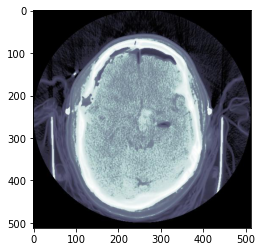

In [168]:
sample_image_path = 'epidural/max_contrast_window/ID_0a3f30540.jpg'
sample_image = plt.imread(sample_image_path)
plt.imshow(sample_image)

Grayscale Image

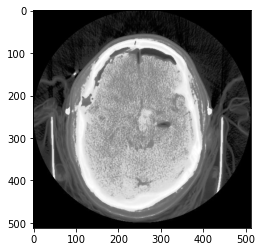

In [169]:
sample_image_gray = color.rgb2gray(sample_image)
plt.imshow(sample_image_gray, cmap=plt.cm.gray)

Rescaled Image No Aliasing

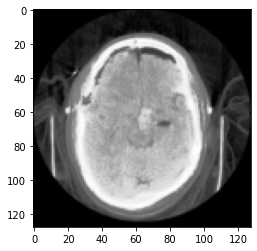

In [170]:
sample_image_rescaled = rescale(sample_image_gray, 0.25, anti_aliasing=True)
plt.imshow(sample_image_rescaled, cmap=plt.cm.gray)

Resized Image Aliasing

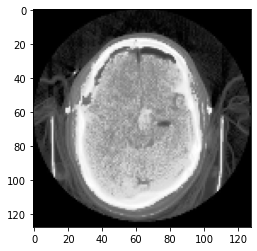

In [171]:
sample_image_resized = resize(sample_image_gray, (sample_image_gray.shape[0] / 4, sample_image_gray.shape[1] / 4), anti_aliasing=False)
plt.imshow(sample_image_resized, cmap=plt.cm.gray)

Downscaled Image

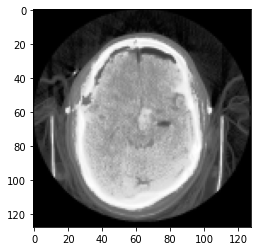

In [172]:
sample_image_downscaled = downscale_local_mean(sample_image_gray, (4, 4))
plt.imshow(sample_image_downscaled, cmap=plt.cm.gray)

Building Dataset of Image + Classifications

In [38]:
training_examples_per_type = 3145
standard_height, standard_width = 512, 512
view = 'max_contrast_window'
hemorrhage_types = ['epidural', 'intraparenchymal', 'intraventricular', 'subarachnoid', 'subdural']

All of the labels are in this csv file

In [39]:
all_labels = pd.read_csv('segmentations/hemorrhage-labels.csv')
all_labels

,Image,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural
0,ID_000012eaf,0,0,0,0,0,0
1,ID_000039fa0,0,0,0,0,0,0
2,ID_00005679d,0,0,0,0,0,0
3,ID_00008ce3c,0,0,0,0,0,0
4,ID_0000950d7,0,0,0,0,0,0
...,...,...,...,...,...,...,...
752798,ID_ffff82e46,0,0,0,0,0,0
752799,ID_ffff922b9,1,0,0,1,0,0
752800,ID_ffffb670a,1,0,0,0,1,0
752801,ID_ffffcbff8,0,0,0,0,0,0


get_image_path determines what directory the image will reside in and return the corresponding path: e.g. images with no hemorrhage are in the normal directory, images with a hemorrhage of multiple different types are in the multi directory, the images of only a single hemorrhage type are in that corresponding hemorrhage directory  

In [40]:
def get_image_path(row, view):
    if row[1] == 0:
        return f'normal/{view}/{row[0]}.jpg'
    elif row[2:].sum() > 1:
        return f'multi/{view}/{row[0]}.jpg'
    else:
        for i in range(len(hemorrhage_types)):
            if row[2 + i] == 1:
                return f'{hemorrhage_types[i]}/{view}/{row[0]}.jpg'

using get_image_path, we input a column in each row describing the image path for that image

In [41]:
all_labels.insert(1, 'ImagePath', all_labels.apply(lambda row: get_image_path(row, view), axis=1))
all_labels

,Image,ImagePath,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural
0,ID_000012eaf,normal/max_contrast_window/ID_000012eaf.jpg,0,0,0,0,0,0
1,ID_000039fa0,normal/max_contrast_window/ID_000039fa0.jpg,0,0,0,0,0,0
2,ID_00005679d,normal/max_contrast_window/ID_00005679d.jpg,0,0,0,0,0,0
3,ID_00008ce3c,normal/max_contrast_window/ID_00008ce3c.jpg,0,0,0,0,0,0
4,ID_0000950d7,normal/max_contrast_window/ID_0000950d7.jpg,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
752798,ID_ffff82e46,normal/max_contrast_window/ID_ffff82e46.jpg,0,0,0,0,0,0
752799,ID_ffff922b9,intraventricular/max_contrast_window/ID_ffff92...,1,0,0,1,0,0
752800,ID_ffffb670a,subarachnoid/max_contrast_window/ID_ffffb670a.jpg,1,0,0,0,1,0
752801,ID_ffffcbff8,normal/max_contrast_window/ID_ffffcbff8.jpg,0,0,0,0,0,0


Remove the rows whose images are not available. We determine which images are not available by checking if they are in the file directories using the exists function

In [45]:
available_labels = all_labels[list(map(exists, all_labels['ImagePath']))]
available_labels

,Image,ImagePath,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural
0,ID_000012eaf,normal/max_contrast_window/ID_000012eaf.jpg,0,0,0,0,0,0
1,ID_000039fa0,normal/max_contrast_window/ID_000039fa0.jpg,0,0,0,0,0,0
2,ID_00005679d,normal/max_contrast_window/ID_00005679d.jpg,0,0,0,0,0,0
3,ID_00008ce3c,normal/max_contrast_window/ID_00008ce3c.jpg,0,0,0,0,0,0
4,ID_0000950d7,normal/max_contrast_window/ID_0000950d7.jpg,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
752755,ID_fffc60817,multi/max_contrast_window/ID_fffc60817.jpg,1,0,1,1,0,0
752769,ID_fffd00949,subarachnoid/max_contrast_window/ID_fffd00949.jpg,1,0,0,0,1,0
752783,ID_fffe2edb8,multi/max_contrast_window/ID_fffe2edb8.jpg,1,0,1,1,0,0
752799,ID_ffff922b9,intraventricular/max_contrast_window/ID_ffff92...,1,0,0,1,0,0


If the image corresponding to an image path does not have the standard size we're expecting (512 x 512), remove that row

In [46]:
def is_correct_size(image_path):
    width, height = Image.open(image_path).size
    return width == standard_width and height == standard_height

In [47]:
usable_labels = available_labels[list(map(is_correct_size, available_labels['ImagePath']))]
usable_labels

,Image,ImagePath,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural
0,ID_000012eaf,normal/max_contrast_window/ID_000012eaf.jpg,0,0,0,0,0,0
1,ID_000039fa0,normal/max_contrast_window/ID_000039fa0.jpg,0,0,0,0,0,0
2,ID_00005679d,normal/max_contrast_window/ID_00005679d.jpg,0,0,0,0,0,0
3,ID_00008ce3c,normal/max_contrast_window/ID_00008ce3c.jpg,0,0,0,0,0,0
4,ID_0000950d7,normal/max_contrast_window/ID_0000950d7.jpg,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
752755,ID_fffc60817,multi/max_contrast_window/ID_fffc60817.jpg,1,0,1,1,0,0
752769,ID_fffd00949,subarachnoid/max_contrast_window/ID_fffd00949.jpg,1,0,0,0,1,0
752783,ID_fffe2edb8,multi/max_contrast_window/ID_fffe2edb8.jpg,1,0,1,1,0,0
752799,ID_ffff922b9,intraventricular/max_contrast_window/ID_ffff92...,1,0,0,1,0,0


We will only be getting a certain # of training examples for each type of classification. First, get a set amount of images that are classfied as no hemorrhage

In [48]:
normal_labels = usable_labels[usable_labels['any'] == 0].sample(training_examples_per_type, random_state=0)
normal_labels

,Image,ImagePath,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural
5667,ID_01f4d6cfa,normal/max_contrast_window/ID_01f4d6cfa.jpg,0,0,0,0,0,0
5914,ID_020b5fdc2,normal/max_contrast_window/ID_020b5fdc2.jpg,0,0,0,0,0,0
158,ID_000e1b81f,normal/max_contrast_window/ID_000e1b81f.jpg,0,0,0,0,0,0
3710,ID_01472d4a6,normal/max_contrast_window/ID_01472d4a6.jpg,0,0,0,0,0,0
8345,ID_02e0469a3,normal/max_contrast_window/ID_02e0469a3.jpg,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
2897,ID_00fadc852,normal/max_contrast_window/ID_00fadc852.jpg,0,0,0,0,0,0
7740,ID_02a714750,normal/max_contrast_window/ID_02a714750.jpg,0,0,0,0,0,0
7812,ID_02aec1da3,normal/max_contrast_window/ID_02aec1da3.jpg,0,0,0,0,0,0
218,ID_0013495b2,normal/max_contrast_window/ID_0013495b2.jpg,0,0,0,0,0,0


Then, get a set amount of training examples for each distinct type of hemorrhage. The epidural DataFrame is printed as an example

In [49]:
hemorrhage_labels = dict()
for hemorrhage in hemorrhage_types:
    hemorrhage_labels[hemorrhage] = usable_labels[usable_labels[hemorrhage] == 1].sample(training_examples_per_type, random_state=0)
hemorrhage_labels['epidural']

,Image,ImagePath,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural
100708,ID_2238a16d2,multi/max_contrast_window/ID_2238a16d2.jpg,1,1,0,0,1,0
733641,ID_f9758e16f,multi/max_contrast_window/ID_f9758e16f.jpg,1,1,0,0,0,1
278751,ID_5e830ddd1,multi/max_contrast_window/ID_5e830ddd1.jpg,1,1,0,1,0,1
165982,ID_385bfea1f,epidural/max_contrast_window/ID_385bfea1f.jpg,1,1,0,0,0,0
75143,ID_197585b09,multi/max_contrast_window/ID_197585b09.jpg,1,1,0,0,0,1
...,...,...,...,...,...,...,...,...
186120,ID_3f36d865e,epidural/max_contrast_window/ID_3f36d865e.jpg,1,1,0,0,0,0
201737,ID_4482a0ddf,epidural/max_contrast_window/ID_4482a0ddf.jpg,1,1,0,0,0,0
393391,ID_8586e65da,epidural/max_contrast_window/ID_8586e65da.jpg,1,1,0,0,0,0
624833,ID_d458e0d0b,epidural/max_contrast_window/ID_d458e0d0b.jpg,1,1,0,0,0,0


Combine all the labels that were selected into one DataFrame to make it easier to read the image data all at once

In [50]:
labels = normal_labels
for hemorrhage in hemorrhage_types:
    labels = labels.append(hemorrhage_labels[hemorrhage])
labels

,Image,ImagePath,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural
5667,ID_01f4d6cfa,normal/max_contrast_window/ID_01f4d6cfa.jpg,0,0,0,0,0,0
5914,ID_020b5fdc2,normal/max_contrast_window/ID_020b5fdc2.jpg,0,0,0,0,0,0
158,ID_000e1b81f,normal/max_contrast_window/ID_000e1b81f.jpg,0,0,0,0,0,0
3710,ID_01472d4a6,normal/max_contrast_window/ID_01472d4a6.jpg,0,0,0,0,0,0
8345,ID_02e0469a3,normal/max_contrast_window/ID_02e0469a3.jpg,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
617750,ID_d1ef577cf,subdural/max_contrast_window/ID_d1ef577cf.jpg,1,0,0,0,0,1
998,ID_0057098ae,subdural/max_contrast_window/ID_0057098ae.jpg,1,0,0,0,0,1
501476,ID_aa412d966,multi/max_contrast_window/ID_aa412d966.jpg,1,0,0,0,1,1
189548,ID_4065a3887,subdural/max_contrast_window/ID_4065a3887.jpg,1,0,0,0,0,1


Some examples may have been added multiple times because they are classified as multiple types of hemorrhages, so remove the duplicate rows of data

In [51]:
labels = labels.drop_duplicates().reset_index(drop=True)
labels

,Image,ImagePath,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural
0,ID_01f4d6cfa,normal/max_contrast_window/ID_01f4d6cfa.jpg,0,0,0,0,0,0
1,ID_020b5fdc2,normal/max_contrast_window/ID_020b5fdc2.jpg,0,0,0,0,0,0
2,ID_000e1b81f,normal/max_contrast_window/ID_000e1b81f.jpg,0,0,0,0,0,0
3,ID_01472d4a6,normal/max_contrast_window/ID_01472d4a6.jpg,0,0,0,0,0,0
4,ID_02e0469a3,normal/max_contrast_window/ID_02e0469a3.jpg,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
18296,ID_d1ef577cf,subdural/max_contrast_window/ID_d1ef577cf.jpg,1,0,0,0,0,1
18297,ID_0057098ae,subdural/max_contrast_window/ID_0057098ae.jpg,1,0,0,0,0,1
18298,ID_aa412d966,multi/max_contrast_window/ID_aa412d966.jpg,1,0,0,0,1,1
18299,ID_4065a3887,subdural/max_contrast_window/ID_4065a3887.jpg,1,0,0,0,0,1


Now that we have a master list of images + labels to use, let's actually fill each row of the DataFrame with the corresponding image data

get_image_data applies a vector operation to each row in the labels DataFrame that retrieves the image data based on the image path. the function returns a new DataFrame with each row representing one image. the index of each row in the new image data DataFrame corresponds to the index of each row in the old labels DataFrame, making it seamless to combine the two

get_data allows for customization of what type of image to read (grayscale vs rgb, max_contrast_window vs subdural vs different view, how much to downsample each image, etc.)

In [52]:
def get_image_data(image_labels, grayscale=False, downsample_factor=None):
    return image_labels.apply(lambda row: get_data(row, grayscale, downsample_factor), axis=1, result_type='expand')
def get_data(row, grayscale=True, downsample_factor=None):
    if int(row.name) % 100 == 0:
        print(f'{row.name} Images Read')
        
    image = plt.imread(row[1])
    if image.shape != (standard_height, standard_width, 3):
        image = np.zeros((standard_height, standard_width, 3))
    
    if grayscale:
        image = color.rgb2gray(image)
    
    if downsample_factor is not None:
        image = rescale(image, downsample_factor, anti_aliasing=True)
        
    return image.flatten()

retrieve pixel data for each image in labels file

In [53]:
image_data = get_image_data(labels, grayscale=True, downsample_factor=0.25)
image_data

0 Images Read
100 Images Read
200 Images Read
300 Images Read
400 Images Read
500 Images Read
600 Images Read
700 Images Read
800 Images Read
900 Images Read
1000 Images Read
1100 Images Read
1200 Images Read
1300 Images Read
1400 Images Read
1500 Images Read
1600 Images Read
1700 Images Read
1800 Images Read
1900 Images Read
2000 Images Read
2100 Images Read
2200 Images Read
2300 Images Read
2400 Images Read
2500 Images Read
2600 Images Read
2700 Images Read
2800 Images Read
2900 Images Read
3000 Images Read
3100 Images Read
3200 Images Read
3300 Images Read
3400 Images Read
3500 Images Read
3600 Images Read
3700 Images Read
3800 Images Read
3900 Images Read
4000 Images Read
4100 Images Read
4200 Images Read
4300 Images Read
4400 Images Read
4500 Images Read
4600 Images Read
4700 Images Read
4800 Images Read
4900 Images Read
5000 Images Read
5100 Images Read
5200 Images Read
5300 Images Read
5400 Images Read
5500 Images Read
5600 Images Read
5700 Images Read
5800 Images Read
5900 Imag

,0,1,2,3,4,5,6,7,8,9,...,16374,16375,16376,16377,16378,16379,16380,16381,16382,16383
0,0.176128,0.176765,0.176037,0.163113,0.166083,0.182620,0.174673,0.177472,0.174163,1.665602e-01,...,0.097850,0.108344,0.125145,0.105169,0.121053,0.123569,0.126484,0.130485,0.120768,0.118604
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.194958,0.154514,0.127692,0.164184,0.158168,0.140480,0.147683,0.164980,0.144930,1.307494e-01,...,0.375928,0.369383,0.379804,0.375893,0.367718,0.371026,0.400871,0.436808,0.442879,0.448418
3,0.087215,0.079240,0.076401,0.091629,0.078743,0.077312,0.078626,0.057542,0.049453,6.284368e-02,...,0.098390,0.063488,0.083515,0.108986,0.104655,0.093633,0.094241,0.120462,0.107320,0.102138
4,0.008651,0.004700,0.001479,0.003986,0.002609,0.000644,0.002581,0.001804,0.000242,2.142118e-07,...,0.225490,0.211199,0.216425,0.225333,0.214360,0.233186,0.216167,0.223220,0.217947,0.218500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18296,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
18297,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
18298,0.112985,0.114498,0.128912,0.106826,0.128540,0.132195,0.112461,0.094848,0.093858,1.031995e-01,...,0.150922,0.169018,0.167451,0.161535,0.153922,0.166517,0.172181,0.167094,0.158782,0.162278
18299,0.079267,0.089631,0.099556,0.104249,0.096686,0.097938,0.082698,0.102748,0.088685,9.467082e-02,...,0.218619,0.210665,0.231792,0.255857,0.259348,0.260824,0.260744,0.276087,0.291454,0.293790


combine the labels DataFrame and the image data DataFrame to form one unified DataFrame with all the data. remove the image data that unable to be parsed (all pixels sum up to 0)

In [54]:
total_data = pd.concat([labels, image_data], axis=1)
image_data_column_list = [i for i in range(image_data.shape[1])]
total_data = total_data[(total_data[image_data_column_list].sum(axis=1) != 0)]
total_data

,Image,ImagePath,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural,0,1,...,16374,16375,16376,16377,16378,16379,16380,16381,16382,16383
0,ID_01f4d6cfa,normal/max_contrast_window/ID_01f4d6cfa.jpg,0,0,0,0,0,0,0.176128,0.176765,...,0.097850,0.108344,0.125145,0.105169,0.121053,0.123569,0.126484,0.130485,0.120768,0.118604
1,ID_020b5fdc2,normal/max_contrast_window/ID_020b5fdc2.jpg,0,0,0,0,0,0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,ID_000e1b81f,normal/max_contrast_window/ID_000e1b81f.jpg,0,0,0,0,0,0,0.194958,0.154514,...,0.375928,0.369383,0.379804,0.375893,0.367718,0.371026,0.400871,0.436808,0.442879,0.448418
3,ID_01472d4a6,normal/max_contrast_window/ID_01472d4a6.jpg,0,0,0,0,0,0,0.087215,0.079240,...,0.098390,0.063488,0.083515,0.108986,0.104655,0.093633,0.094241,0.120462,0.107320,0.102138
4,ID_02e0469a3,normal/max_contrast_window/ID_02e0469a3.jpg,0,0,0,0,0,0,0.008651,0.004700,...,0.225490,0.211199,0.216425,0.225333,0.214360,0.233186,0.216167,0.223220,0.217947,0.218500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18296,ID_d1ef577cf,subdural/max_contrast_window/ID_d1ef577cf.jpg,1,0,0,0,0,1,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
18297,ID_0057098ae,subdural/max_contrast_window/ID_0057098ae.jpg,1,0,0,0,0,1,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
18298,ID_aa412d966,multi/max_contrast_window/ID_aa412d966.jpg,1,0,0,0,1,1,0.112985,0.114498,...,0.150922,0.169018,0.167451,0.161535,0.153922,0.166517,0.172181,0.167094,0.158782,0.162278
18299,ID_4065a3887,subdural/max_contrast_window/ID_4065a3887.jpg,1,0,0,0,0,1,0.079267,0.089631,...,0.218619,0.210665,0.231792,0.255857,0.259348,0.260824,0.260744,0.276087,0.291454,0.293790


we now have our dataset

Building Logistic Regression Models to Classify Types of Hemorrhages

In [55]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

we will be building 6 different logistic regression classifiers. each will determine whether or not the image belongs to a given class

on average for each classification in the dataset, there are about 17% of training examples that belong to that classification and 83% that don't. it is inefficient to input a lot of training examples that belong to the negative class into a classifier, so for each classifier we build a custom dataset where 50% of the training examples belong to the positive class and 50% to the negative.

In [56]:
def get_balanced_dataset(data, column):
    positive_data = data[data[column] == 1].sample(training_examples_per_type, random_state=0)
    negative_data = data[data[column] == 0].sample(training_examples_per_type, random_state=0)
    return positive_data.append(negative_data)

epidural custom dataset for example: 50% of images are of class epidural, 50% aren't

In [57]:
get_balanced_dataset(total_data, 'epidural')

,Image,ImagePath,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural,0,1,...,16374,16375,16376,16377,16378,16379,16380,16381,16382,16383
3567,ID_3548b6e47,epidural/max_contrast_window/ID_3548b6e47.jpg,1,1,0,0,0,0,0.097827,0.110203,...,0.231457,0.181929,0.210159,0.235625,0.243665,0.226798,0.217793,0.200388,0.210863,0.240653
6204,ID_4e8abd707,epidural/max_contrast_window/ID_4e8abd707.jpg,1,1,0,0,0,0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4327,ID_6da0fbd46,epidural/max_contrast_window/ID_6da0fbd46.jpg,1,1,0,0,0,0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3828,ID_404a9e458,epidural/max_contrast_window/ID_404a9e458.jpg,1,1,0,0,0,0,0.091563,0.091536,...,0.337795,0.336784,0.327188,0.329424,0.334011,0.329989,0.329940,0.325051,0.322101,0.325606
3450,ID_34d6c8f77,multi/max_contrast_window/ID_34d6c8f77.jpg,1,1,0,0,1,0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16683,ID_fd587ed00,multi/max_contrast_window/ID_fd587ed00.jpg,1,0,1,0,1,1,0.059985,0.051891,...,0.253925,0.257570,0.251759,0.252825,0.254025,0.249340,0.254413,0.260373,0.257957,0.257166
10425,ID_64a3ac30b,intraventricular/max_contrast_window/ID_64a3ac...,1,0,0,1,0,0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
15305,ID_1b8b7c9c1,multi/max_contrast_window/ID_1b8b7c9c1.jpg,1,0,1,0,1,0,0.370127,0.375757,...,0.463157,0.462986,0.460520,0.454764,0.453640,0.453459,0.454346,0.452885,0.448481,0.448336
15487,ID_c74607597,subdural/max_contrast_window/ID_c74607597.jpg,1,0,0,0,0,1,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


The following function builds a logistic regression model for a given positive class (type of hemorrhage: epidural, subdural, etc.) and prints relevant statistics about the accuracy of predicting that type

In [58]:
def build_model(data, column, iterations=2500, solve_with='lbfgs'):
    balanced_data = get_balanced_dataset(data, column)
    X_train, X_test, y_train, y_test = train_test_split(balanced_data[image_data_column_list], balanced_data[column], test_size=0.2, random_state=0)
    model = LogisticRegression(random_state=0, max_iter=iterations, solver=solve_with,verbose=1).fit(X_train, y_train)
    print(f'Score: {model.score(X_test, y_test)}')
    y_predict = model.predict(X_test)
    results = confusion_matrix(y_test, y_predict)
    print(f'Precision: {results[1][1]/(results[1][1] + results[0][1])}')
    print(f'Recall: {results[1][1]/(results[1][1] + results[1][0])}')
    print(results)
    return model

Detecting if Image Has Any Hemorrhage

In [59]:
any_hemorrhage_logistic_model = build_model(total_data, 'any', iterations=100, solve_with='newton-cg')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.1min finished


Score: 0.6550079491255962
Precision: 0.6466165413533834
Recall: 0.6836248012718601
[[394 235]
 [199 430]]


Determining if Image Specifically Has Hemorrhage of Type Epidural

In [60]:
epidural_logistic_model = build_model(total_data, 'epidural', iterations=100, solve_with='newton-cg')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.7min finished


Score: 0.7289348171701113
Precision: 0.7051282051282052
Recall: 0.7869634340222575
[[422 207]
 [134 495]]


Detecting Other Types of Hemorrhages

In [194]:
intraparenchymal_logistic_model = build_model(total_data, 'intraparenchymal', iterations=100, solve_with='newton-cg')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.5min finished


Score: 0.5802861685214626
Precision: 0.5766312594840668
Recall: 0.604133545310016
[[350 279]
 [249 380]]


In [195]:
intraventricular_logistic_model = build_model(total_data, 'intraventricular', iterations=100, solve_with='newton-cg')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.6min finished


Score: 0.6629570747217806
Precision: 0.6666666666666666
Recall: 0.6518282988871225
[[424 205]
 [219 410]]


In [196]:
subarachnoid_logistic_model = build_model(total_data, 'subarachnoid', iterations=100, solve_with='newton-cg')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.6min finished


Score: 0.5620031796502385
Precision: 0.5607476635514018
Recall: 0.5723370429252782
[[347 282]
 [269 360]]


In [197]:
subdural_logistic_model = build_model(total_data, 'subdural', iterations=100, solve_with='newton-cg')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.4min finished


Score: 0.5763116057233705
Precision: 0.5745341614906833
Recall: 0.5882352941176471
[[355 274]
 [259 370]]


Things to Try: different number of examples, different picture types (max_contrast vs other types), RGB vs grayscale, all pixels vs downsampling, different solvers for logistic regression, different number of iterations

Annotating a Sample Image

In [198]:
epidural_csv_file = 'segmentations/Results_Epidural Hemorrhage Detection_2020-11-16_21.31.26.148.csv'
epidural_image_repo = 'epidural/max_contrast_window'
epidural_image_file = 'ID_004c4b319.jpg'

In [199]:
def get_coords(image, image_csv_file, image_file_name):
    labels = get_labels_csv(image_csv_file, image_file_name)
    coord_list = []
    for label in labels:
        coord = (label['x'] * image.size[0], label['y'] * image.size[1])
        coord_list.append(coord)
    return coord_list
def get_labels_csv(image_csv_file, image_file_name):
    with open(image_csv_file) as csv_file:
        data_reader = csv.reader(csv_file, dialect='excel')
        for row in data_reader:
            if row[1] == image_file_name:
                return json.loads(row[7])
    return None

In [200]:
im = Image.open(f'{epidural_image_repo}/{epidural_image_file}')
features = []
for x in range(im.size[0]):
    for y in range(20):
        features.append(im.getpixel((x, y))[0])
        features.append(im.getpixel((x, y))[1])
        features.append(im.getpixel((x, y))[2])
draw = ImageDraw.Draw(im)
draw.line(get_coords(im, epidural_csv_file, epidural_image_file), fill='red')
im.show()

In [201]:
# the line of code below loads the 'all labels' field in the csv file in json
# coords_lists = json.loads(row[4].replace("'[", "[").replace("]'", "],").replace(',]', ']'))